# FIGURE 1. CELL VIABILITY AND SIGNALING OF AXL MUTANTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sp
import matplotlib.pyplot as plt
from msresist.pre_processing import preprocessing, MeanCenter, Log2T, MergeDfbyMean
from msresist.motifs import FormatName, MapMotifs
from msresist.figures.figure1 import plotClustergram, plotpca_explained, plotpca_ScoresLoadings_plotly, plotVarReplicates, selectpeptides, barplot_UtErlAF154, IndividualTimeCourses, plotPCA
import warnings
warnings.simplefilter("ignore")

sns.set(style="whitegrid", font_scale=1.1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [2]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## CELL VIABILITY

## Cell Survival

In [3]:
r1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR1_Phase.csv")
r2 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR2_Phase.csv')
r3 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv')
r4 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR4_Phase.csv')
lines = ["WT", "KO", "KI", "KD", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F", "Y821F"]
lines_num = ["WT", "KO", "KI", "KD", "634", "643", "698", "726", "750", "821"]

In [4]:
itp = 24
ftp = 96

### Time Course

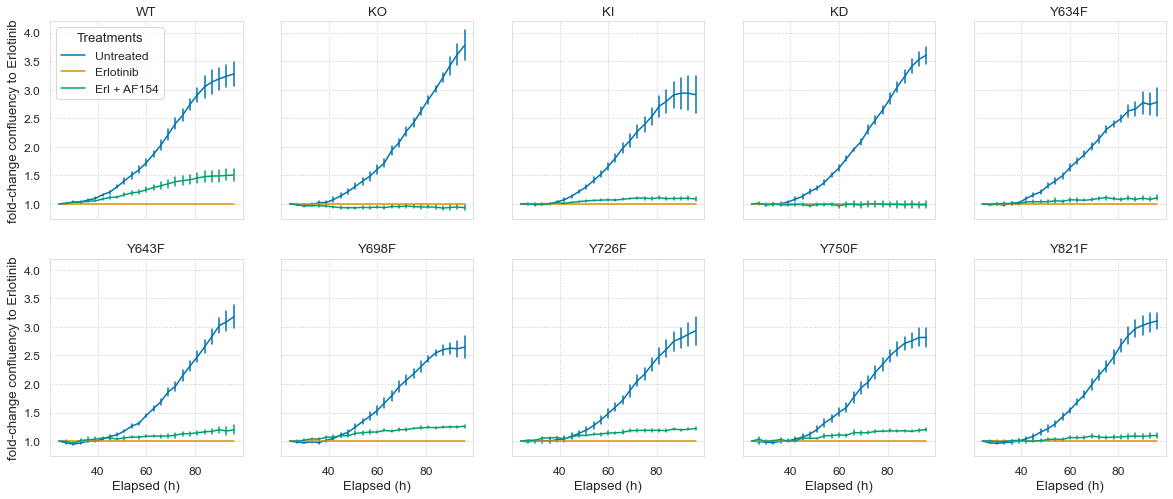

In [5]:
ds = [r1, r2, r3, r4]
t1 = ["UT", "-E", "A/E"]
t2 = ["Untreated", "Erlotinib", "Erl + AF154"]
ylabel = "fold-change confluency to Erlotinib"


IndividualTimeCourses(ds, ftp, lines, t1, t2, ylabel, TimePointFC=itp, TreatmentFC="-E", savefig=True, figsize=(20, 8))

### At specified endpoint

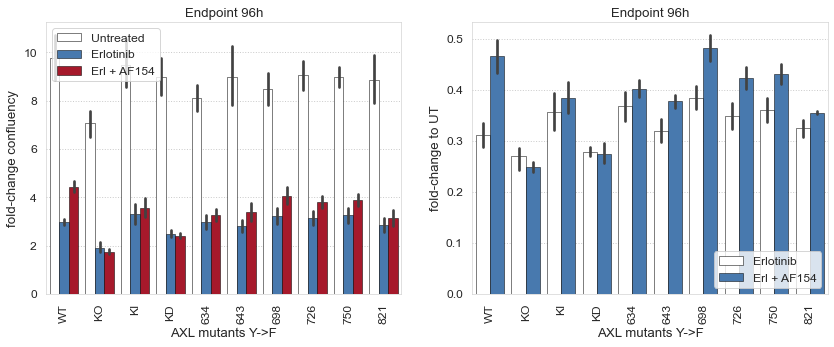

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

itp = 24
ftp = 96

tr1 = ["UT", '-E', '-A/E']
tr2 = ["Untreated", 'Erlotinib', 'Erl + AF154']

c = ["white", "windows blue", "scarlet"]

barplot_UtErlAF154(ax[0], lines_num, ds, ftp, tr1, tr2, "fold-change confluency", "Endpoint 96h", TimePointFC=itp, colors=c)
ax[0].legend(loc=2)

tr1 = ["-E", "-A/E"]
tr2 = ["Erlotinib", "Erl + AF154"]
barplot_UtErlAF154(ax[1], lines_num, ds, ftp, tr1, tr2, "fold-change to UT", "Endpoint 96h", TimePointFC=itp, TreatmentFC="-UT", colors=c)
ax[1].legend(loc=4)

# fig.savefig("AXLmutants_CV_96h.pdf", bbox_inches='tight')

## Cell Death

### Time Course

Counts

In [7]:
red1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR1_RedCount.csv")
red2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR2_RedCount.csv")
red3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR3_RedCount.csv")
red4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR4_RedCount.csv")
red4.columns = red3.columns

Normalize

In [8]:
for jj in range(1, red1.columns.size):
    red1.iloc[: , jj] /= r1.iloc[:, jj]
    red2.iloc[: , jj] /= r2.iloc[:, jj]
    red3.iloc[: , jj] /= r3.iloc[:, jj]
    red4.iloc[: , jj] /= r4.iloc[:, jj]

In [9]:
from msresist.pre_processing import FixColumnLabels

ds = [red1, red2, red3, red4]
# ds = FixColumnLabels(ds)

### Time Course

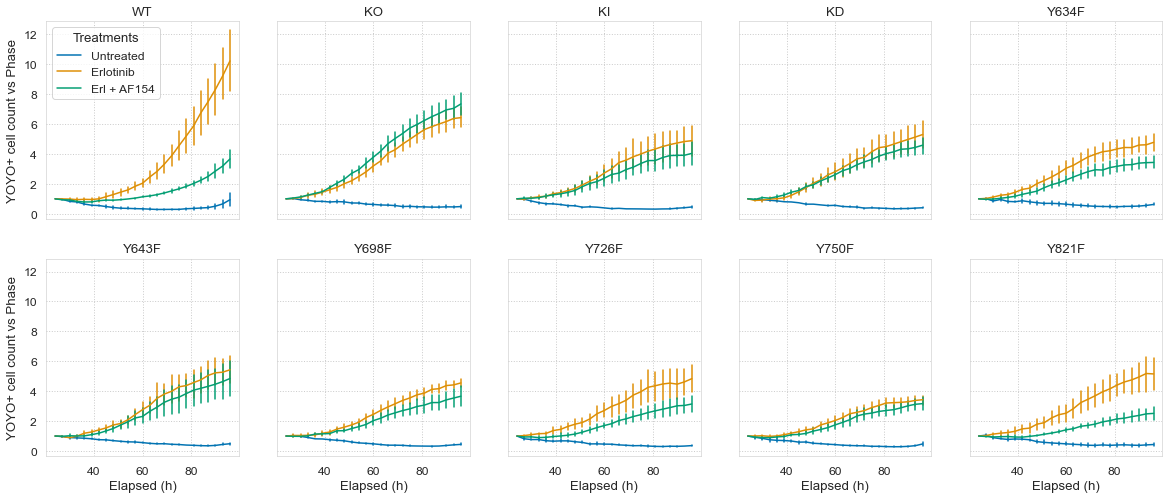

In [10]:
tr1 = ["UT", '-E', '-A/E']
tr2 = ["Untreated", 'Erlotinib', 'Erl + AF154']

ylabel = "YOYO+ cell count vs Phase"
IndividualTimeCourses(ds, ftp, lines, tr1, tr2, ylabel, TimePointFC=itp, TreatmentFC=False, savefig=False, figsize=(20, 8))

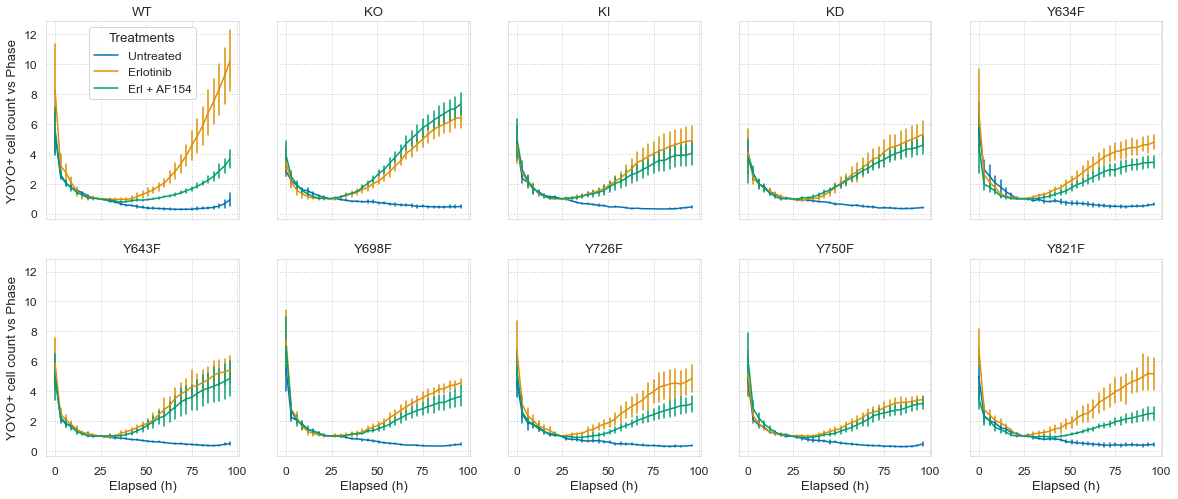

In [11]:
IndividualTimeCourses(ds, ftp, lines, tr1, tr2, ylabel, TimePointFC=False, TreatmentFC=False, savefig=False, figsize=(20, 8))

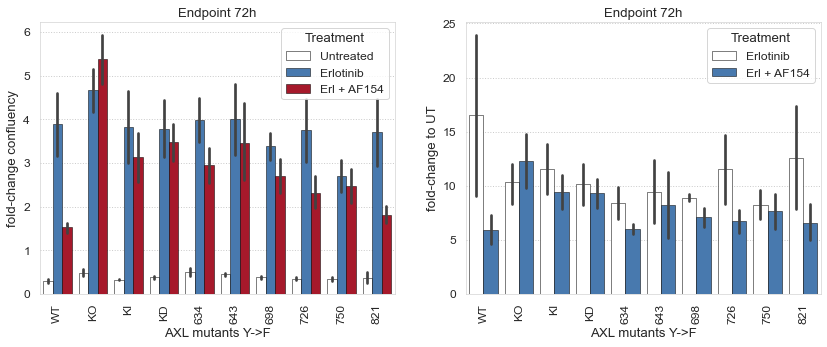

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

ftp = 72

tr1 = ["UT", '-E', '-A/E']
tr2 = ["Untreated", 'Erlotinib', 'Erl + AF154']

c = ["white", "windows blue", "scarlet"]

barplot_UtErlAF154(ax[0], lines_num, ds, ftp, tr1, tr2, "fold-change confluency", "Endpoint 72h", TimePointFC=itp, colors=c)

tr1 = ["-E", "-A/E"]
tr2 = ["Erlotinib", "Erl + AF154"]
barplot_UtErlAF154(ax[1], lines_num, ds, ftp, tr1, tr2, "fold-change to UT", "Endpoint 72h", TimePointFC=itp, TreatmentFC="-UT", colors=c)

## SIGNALING

#### Erlotinib + AF154

In [13]:
A = preprocessing(Axlmuts_ErlAF154=True, Vfilter=False, FCfilter=False, log2T=True, mc_row=True, mc_col=False)
A.columns = list(A.columns[:5]) + ["PC9", "Knock-Out", "Kinase Dead", "Knock-In", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F", "Y821F"]

In [23]:
def plotClustergram(data, title=False, lim=False, robust=True, ylabel="", yticklabels=False, figsize=(10, 10)):
    """ Clustergram plot. """
    g = sns.clustermap(data, method="complete", cmap="bwr", robust=robust, vmax=lim, vmin=-lim, figsize=figsize, yticklabels=yticklabels)
    g.fig.suptitle(title, fontsize=17)
    ax = g.ax_heatmap
    ax.set_ylabel(ylabel)

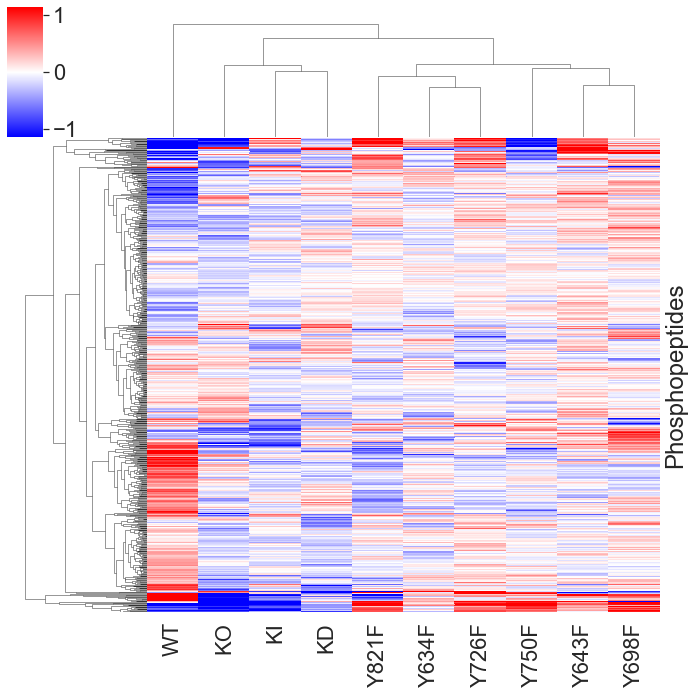

In [24]:
sns.set(style="whitegrid", font_scale=2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

dA = A.set_index(["Gene", "Position"]).select_dtypes(include=float)
dA.columns = lines
plotClustergram(dA, "",  max(np.max(np.abs(dA)) * 0.3), ylabel="Phosphopeptides")

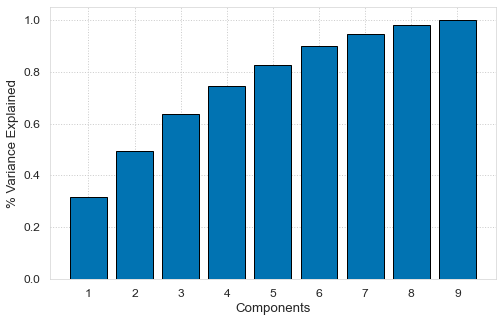

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotpca_explained(ax, dA, dA.shape[1])

In [17]:
plotpca_ScoresLoadings_plotly(dA.T, "PC9 +Erl +F154", "RIN1")

PC1       PC2
Position                    
Y36-p    -0.006252 -0.014443
Y698-p   -0.031607 -0.040229
Y681-p   -0.030702  0.069928


## Selecting and Clustering a subset of kinases of interest

In [ ]:
koi = {
    "AXL":["Y702-p", "Y759-p", "Y866-p"], "EGFR":"Y1197-p", "MET":"Y1003-p", "ERBB2":"Y877-p", "ERBB3":"Y1328-p", "EPHB3":"Y792-p", "GAB1":"Y627-p", "GAB2":"T265-p", "CRK":"Y251-p", 
    "CRKL":"Y251-p", "SHC1":"S426-p", "MAPK3":"Y204-p;T202-p", "MAPK1":"Y187-p;T185-p", "MAPK7":"Y221-p","MAPK9":"Y185-p", "MAPK10":"Y223-p",
    "MAPK12":"Y185-p", "MAPK13":"Y182-p", "MAPK14":"Y182-p", "HIPK1":"T351-p", "HIPK3":"T354-p;T358-p", "BCAR1":"Y128-p", "BCAR3":"Y266-p", "FRK":"Y46-p", 
    "DCBLD2":"Y750-p", "BRK1":"Y63-p", "ARAP1":"Y231-p", "STAT3":"Y686-p", "YES1":["Y446-p", "Y222-p"], "LYN":["Y397-p", "Y508-p"], "SRC":"Y187-p", "CTTN":"Y446-p", "PRKCD":"Y313-p"
    }

In [ ]:
A = A.copy().set_index(["Gene", "Position"])
B = B.copy().set_index(["Gene", "Position"])

In [ ]:
Ams = selectpeptides(A.drop("PC9", axis=1), koi)
Aredd = Ams.set_index(["Gene", "Position"]).iloc[:, 3:].astype("float")

In [ ]:
Bms = selectpeptides(B, koi)
Bredd = Bms.set_index(["Gene", "Position"]).iloc[:, 3:].astype("float")

In [ ]:
plotClustergram(Aredd, "Reduced MS AXL mutants +Erl +F154", max(np.max(np.abs(Aredd)) * 0.3), figsize=(12, 12))

In [ ]:
plotClustergram(Bredd, "Reduced MS AXL mutants +Erlotinib", max(np.max(np.abs(dB)) * 0.3))

### Comparing Overlapping peptides across AXL mutant vs Bypass-treated PC9 Cells

In [ ]:
x = preprocessing(Axlmuts_ErlAF154=True, rawdata=True)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
plotVarReplicates(ax, x)

In [ ]:
x = preprocessing(AXLwt=True, rawdata=True)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
plotVarReplicates(ax, x)

### Compare specific peptides in both replicates

In [ ]:
import matplotlib.cm as cm
from msresist.figures.figure1 import plot_AllSites

In [ ]:
def MSaxl(file):
    b = MeanCenter(Log2T(file), mc_row=True, mc_col=False)
    longnames, shortnames = FormatName(b)
    b["Protein"] = longnames
    b = b.assign(Abbv=shortnames)
    merging_indices = list(b.columns[:3]) + ["Abbv"]
    b = MapMotifs(b, longnames)
    return b

In [ ]:
b1 = pd.read_csv("./msresist/data/Raw/PC9_mutants_ActivatingAb_BR1_raw.csv")
lines = ["PC9", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F", "Y821F"]
b1.columns = list(b1.columns[:3]) + lines

b1 = MSaxl(b1).set_index(["Abbv", "Position"])

In [ ]:
b2 = pd.read_csv("./msresist/data/Raw/PC9_mutants_ActivatingAb_BR2_raw.csv")
b2.columns = list(b2.columns[:3]) + lines

b2 = MSaxl(b2).set_index(["Abbv", "Position"])

In [ ]:
b1.iloc[:, 5:] = b1.iloc[:, 5:].div(b1.iloc[:, 5], axis=0)
b2.iloc[:, 5:] = b2.iloc[:, 5:].div(b2.iloc[:, 5], axis=0)

In [ ]:
b1 = b1.reset_index()
b2 = b2.reset_index()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 8), sharey=False, sharex=True)
plot_AllSites(ax[0, 0], b1.copy(), "AXL", "AXL - BR1")
plot_AllSites(ax[0, 1], b2.copy(), "AXL", "AXL - BR2")
plot_AllSites(ax[0, 2], b1.copy(), "EGFR", "EGFR - BR1")
plot_AllSites(ax[0, 3], b2.copy(), "EGFR", "EGFR - BR2")
plot_AllSites(ax[1, 0], b1.copy(), "MAPK1", "ERK3 - BR1")
plot_AllSites(ax[1, 1], b2.copy(), "MAPK1", "ERK3 - BR2")
plot_AllSites(ax[1, 2], b1.copy(), "MAPK3", "ERK1 - BR1")
plot_AllSites(ax[1, 3], b2.copy(), "MAPK3", "ERK1 - BR2")
plot_AllSites(ax[2, 0], b1.copy(), "GAB1", "GAB1 - BR1")
plot_AllSites(ax[2, 1], b2.copy(), "GAB1", "GAB1 - BR2")
plot_AllSites(ax[2, 2], b1.copy(), "MAPK13", "P38D - BR1")
plot_AllSites(ax[2, 3], b2.copy(), "MAPK13", "P38D - BR2")

plt.tight_layout()